<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Preparation" data-toc-modified-id="Preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Preparation</a></span><ul class="toc-item"><li><span><a href="#Paths" data-toc-modified-id="Paths-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Paths</a></span></li><li><span><a href="#Read-school-locations-from-each-school-year" data-toc-modified-id="Read-school-locations-from-each-school-year-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Read school locations from each school year</a></span></li></ul></li><li><span><a href="#Harmonize-school-names" data-toc-modified-id="Harmonize-school-names-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Harmonize school names</a></span></li><li><span><a href="#Adjust-addresses-and-coordinates-for-schools-with-multiple-differing-entries" data-toc-modified-id="Adjust-addresses-and-coordinates-for-schools-with-multiple-differing-entries-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Adjust addresses and coordinates for schools with multiple differing entries</a></span><ul class="toc-item"><li><span><a href="#Find-schools-which-changed-location" data-toc-modified-id="Find-schools-which-changed-location-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Find schools which changed location</a></span></li></ul></li><li><span><a href="#Convert-go-geopandas-dataframe" data-toc-modified-id="Convert-go-geopandas-dataframe-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Convert go geopandas dataframe</a></span></li><li><span><a href="#Save" data-toc-modified-id="Save-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Save</a></span></li></ul></div>

**Description**: Loads and preprocesses school locations, harmonizes school names according to the conventions used in this project, creates a preliminary treatment indicator, and then saves the data.

---

In [1]:
%matplotlib inline
import pickle
import re
import sys
from itertools import combinations
from pathlib import Path

import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point

sys.path.append('../..')
from src.calculate.distances import vincenty
from src.prepare_data.routes import check_school_name_id_unique
from src.prepare_data.school_locations import (split_school, take_last_values,
                                               uppercase_school_categories,
                                               load_locations)

# Preparation
## Paths

In [2]:
data_path = Path('../../data')
school_locations_path = data_path / 'raw/school_locations'
location_files = [('CPS_School_Locations_SY1516.csv',
                   'SY1516'), ('CPS_School_Locations_SY1415.csv',
                               'SY1415'), ('Units2013_14.csv', 'SY1314')]

## Read school locations from each school year

In [3]:
schools = []
for file, school_year in location_files:
    schools.append(
        load_locations(school_locations_path / file, school_year))

Append all locations together

In [4]:
schools = pd.concat(schools, ignore_index=True, sort=True)

# Harmonize school names

Let's merge harmonized school names from routes dataset by school_id.

First, load the routes dataset

In [5]:
with (data_path / 'processed/routes.pkl').open('rb') as f:
    all_routes = pickle.load(f)

Extract harmonized school names and corresponding school ids

In [6]:
harmonized_names = all_routes[['school_id',
                               'school_name']].drop_duplicates()

Create treatment dummy by school and school year

In [7]:
treated_dummy = all_routes[['school_id', 'school_year']]
assert not any(treated_dummy.duplicated())
del all_routes
treated_dummy['treated'] = 1

Merge new school names, keep old names
for never treated schools

In [8]:
schools['school_name_backup'] = schools['school_name']
schools.drop('school_name', axis='columns', inplace=True)
schools = schools.merge(
    harmonized_names, how='left', on='school_id')

Takes school name of last school year per school id

In [9]:
untreated_schools = schools[schools['school_name']
                                  .isnull()].copy()
untreated_schools.sort_values(['school_id', 'school_year'], inplace=True)
untreated_schools = untreated_schools.groupby('school_id').apply(
    lambda x: x.tail(1)['school_name_backup'])
untreated_schools = untreated_schools.reset_index(0).reset_index(drop=True)

Adjust formatting of school names of untreated schools, i.e. capitalize and Hs -> HS and Es -> ES

In [10]:
untreated_schools['school_name_backup'] = untreated_schools[
    'school_name_backup'].str.title().apply(uppercase_school_categories)

Drop school_name_backup and merge newly created column
school_name_backup, which contains (at least for all untreated schools)
the school name of the last school year in the dataset
as described above

In [11]:
schools.drop('school_name_backup', axis='columns', inplace=True)
schools = schools.merge(
    untreated_schools, how='left', on='school_id')

Harmonize school name for all untreated schools

In [12]:
schools.loc[schools['school_name'].isnull(),
                  'school_name'] = schools.loc[schools[
                      'school_name'].isnull(), 'school_name_backup']
schools.drop('school_name_backup', axis='columns', inplace=True)

Merge treatment dummy

In [13]:
schools = schools.merge(
    treated_dummy, how='left', on=['school_id', 'school_year'])
assert any(schools['treated'].isnull())
schools.loc[schools['treated'].isnull(), 'treated'] = 0

# Adjust addresses and coordinates for schools with multiple differing entries

In [14]:
schools = schools.sort_values(
    ['school_name', 'school_year']).reset_index(drop=True)

## Find schools which changed location

Check GPS coordinates

In [15]:
schools = pd.concat(
    [
        schools,
        schools.duplicated(['school_name', 'lat', 'lon'],
                                    keep=False).rename('duplicated')
    ],
    axis='columns')

duplicated_analysis = schools.groupby('school_name').filter(
    lambda x: not x['duplicated'].all() and len(x) > 1).sort_values(
        'school_name').reset_index(drop=True)

Check maximum difference in GPS coordinates

In [16]:
def mark_problems(x, max_dist_allowed=10):
    """Marks groups where the highest distance is higher
    than max_dist_allowed.
    
    Parameters
    ----------
    x : pd.DataFrame
        Intended for a groupby by school_name
        
    max_dist_allowed : int
        Maximum distance in meters allowed
        
    Returns
    -------
    pd.DataFrame
        Same as x but with additional columns problem
        and max_dist
    """
    x_temp = x[['lat', 'lon']].drop_duplicates()
    combos = list(combinations(x_temp.values, 2))
    distances = map(lambda p: vincenty(p[0], p[1]), combos)
    max_dist = max(distances, default=0)
    x['problem'] = True if max_dist > max_dist_allowed else False
    x['max_dist'] = max_dist
    return x

In [17]:
problems = duplicated_analysis.groupby('school_name').apply(
    mark_problems, max_dist_allowed=10).query(
        'problem == True').sort_values('school_name')

In [18]:
problems.shape

(285, 20)

In [19]:
problems_nodup = problems.drop_duplicates('school_name')

In [20]:
len(problems_nodup)

97

In [21]:
problems_nodup['max_dist'].describe()

count       97.000000
mean      1270.561198
std       4488.314103
min         11.436303
25%         47.994325
50%         94.692743
75%        148.097344
max      27938.181904
Name: max_dist, dtype: float64

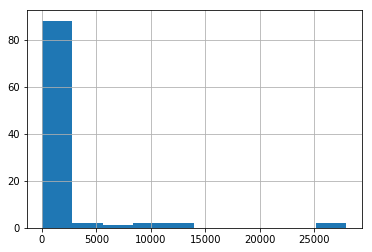

In [22]:
problems_nodup['max_dist'].hist();

In [23]:
problems = problems.sort_values(['school_name', 'school_year'])

Create dataset of schools which moved.

In [24]:
all_schools_with_diff = duplicated_analysis.groupby('school_name').apply(
    mark_problems, max_dist_allowed=0).query('problem == True').sort_values(
        'school_name').drop(
            ['problem', 'duplicated'], axis='columns')

In [25]:
high_diff_schools = all_schools_with_diff.loc[
    all_schools_with_diff['max_dist'] >= 500, 'school_name'].unique().tolist()

high_diff_schools

['Chi Arts',
 'Frazier Charter',
 'Intrinsic HS',
 'Magic Johnson - Roseland HS',
 'Noble - Academy HS',
 'Ombudsman - Northwest HS',
 'Ombudsman - South HS',
 'Ombudsman - West HS',
 'Urban Prep Chtr Bronzeville',
 'YCCS - Houston',
 'YCCS - Innovations']

In [26]:
schools = schools.sort_values(['school_name', 'school_year'])

There are 11 schools which seemed to have moved in the period of interest. The following presents a dictionary, where the value is the number of the first oberversation number form where on the schools seemed to have changed (zero-indexed).

NOTE: This would need to be automated if school years where to be extended.

In [27]:
moved_schools = {
    'Chi Arts': 1,
    'Frazier Charter': 1,
    'Intrinsic HS': 1,
    'Magic Johnson - Roseland HS': 1,
    'Noble - Academy HS': 1,
    'Ombudsman - Northwest HS': 1,
    'Ombudsman - South HS': 1,
    'Ombudsman - West HS': 1,
    'Urban Prep Chtr Bronzeville': 1,
    'YCCS - Houston': 2,
    'YCCS - Innovations': 1
}

Split schools which moved into old and new entries by date of move

In [28]:
schools = schools.groupby('school_name').apply(
    split_school, moved_schools=moved_schools)

Take last values for coordinates and address

In [29]:
schools = schools.groupby('school_name').apply(
    take_last_values)

# Convert go geopandas dataframe

Coordinatesystem to use

In [30]:
crs = {'init': 'epsg:4326'}

Convert dataframe

In [31]:
loc_shapely = [
    Point(lon, lat)
    for lon, lat in zip(schools['lon'], schools['lat'])
]
schools = gpd.GeoDataFrame(
    data=schools, geometry=loc_shapely, crs=crs)

# Save

Make sure that only one school id corresponds to each name
and other way around

In [32]:
check_school_name_id_unique(schools)

Save school locations

In [33]:
schools = schools.sort_values(['school_name', 'school_year'])
schools = schools.reset_index(drop=True)
if not (data_path / 'interim').is_dir():
        (data_path / 'interim').mkdir()
with (data_path / 'interim/schools.pkl').open('wb') as f:
    pickle.dump(schools, f)